In [1]:
# !sudo pip install carvekit

In [ ]:
!viton_env/bin/pip install config==0.5.1 einops==0.7.0 onnxruntime==1.16.2

**upper_body**

train_pairs: 13563

test_pairs_paired: 1800

test_pairs_unpaired: 1800

**dresses**

train_pairs: 27678

test_pairs_paired: 1800

test_pairs_unpaired: 1800

**lower_body**

train_pairs: 7151

test_pairs_paired: 1800

test_pairs_unpaired: 1800

Total train samples: 48392

In [1]:
import sys
import os
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from scipy.ndimage import binary_dilation
import json
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
from PIL import Image
from typing import Literal, List
import random
sys.path.append('../vinhdq_phucnph/CatVTON')
sys.path.append('../vinhdq_phucnph/CatVTON/model')
from model.cloth_masker import AutoMasker, MASK_DENSE_PARTS, MASK_CLOTH_PARTS, LIP_MAPPING, ATR_MAPPING, DENSE_INDEX_MAP
from model.mask_refiner import MaskRefiner
import os
from dataclasses import dataclass

/home/jupyter/hungbd/viton_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NUM_UPPER_TRAIN_SAMPLES = 13563
NUM_DRESSES_TRAIN_SAMPLES = 27678
NUM_LOWER_TRAIN_SAMPLES = 7151

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = (512, 384)  # the generated image resolution
    train_batch_size = 6
    eval_batch_size = 6  # how many images to sample during evaluation
    num_epochs = 20
    gradient_accumulation_steps = 1
    learning_rate = 1e-3
    lr_warmup_steps = 500
    save_image_epochs = 5
    save_model_epochs = 1
    mixed_precision = "no"  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = "mask_checkpoint"  # the model name locally and on the HF Hub
    # device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    device = "cpu"
    num_steps=None
    num_samples=1000

#     push_to_hub = True  # whether to upload the saved model to the HF Hub
#     hub_model_id = "<your-username>/<my-awesome-model>"  # the name of the repository to create on the HF Hub
#     hub_private_repo = False
#     overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0


config = TrainingConfig()

In [4]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [5]:
from dataloader.dresscode.dataloader import DataLoader as DressCode_DataLoader
from dataloader.dresscode.dataset import Dataset as DressCode_Dataset

In [6]:
# from dataclasses import dataclass

# @dataclass
# class Args:
#     exp_name: str = None
#     category: str = "dress"
#     dataroot: str = Exception()
#     data_pairs: str = "{}_pairs"
#     checkpoint_dir: str = ""
#     batch_size: int = 8
#     workers: int = 0
#     epochs: int = 150
#     step: int = 100000
#     display_count: int = 1000
#     shuffle: bool = True
#     height: int = 512
#     width: int = 384
#     radius: int = 5
    

# args = Args(dataroot="../datasets/DressCode")
    

# dataset_train = DressCode_Dataset(args, 
#                         dataroot_path=args.dataroot, 
#                         category=["lower_body"],
#                         phase='train',
#                         order='paired',
#                         size=(int(args.height), int(args.width)))

# dataloader_train = DressCode_DataLoader(args, dataset_train, dist_sampler=False)

In [7]:
# batch = dataloader_train.next_batch()

In [8]:
# plt.figure(figsize=(100, 50))

# i = 0

# plt.subplot(2, 4, 1)
# plt.imshow(batch["image"][i].permute(1, 2, 0)*0.5 + 0.5)
# plt.axis('off')

# plt.subplot(2, 4, 2)
# plt.imshow(batch["cloth"][i].permute(1, 2, 0)*0.5 + 0.5)
# plt.axis('off')

# plt.subplot(2, 4, 3)
# image = Image.open(os.path.join(args.dataroot, "lower_body", "images", batch["im_name"][i]))
# image = image.resize((args.width, args.height))
# image = np.array(image)
# mask = batch["person_mask"][i] == 1
# mask = binary_dilation(mask, structure=np.ones((30, 30)))
# image[mask] = [128, 128, 128]
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(2, 4, 4)
# image = Image.open(os.path.join(args.dataroot, "lower_body", "images", batch["im_name"][i]))
# image = image.resize((args.width, args.height))
# image = np.array(image)
# mask = batch["cloth_mask"][i] == 1
# image[mask] = [128, 128, 128]
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(2, 4, 5)
# plt.imshow(batch["im_pose"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 6)
# plt.imshow(batch["skeleton"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 7)
# plt.imshow(batch["m"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 8)
# plt.imshow(batch["parse_mask_total"][i])
# plt.axis('off')

# plt.show()

In [9]:
# plt.figure(figsize=(100, 50))

# i = 1

# plt.subplot(2, 4, 1)
# plt.imshow(batch["image"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 2)
# plt.imshow(batch["cloth"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 3)
# image = Image.open(os.path.join(args.dataroot, "lower_body", "images", batch["im_name"][i]))
# image = image.resize((args.width, args.height))
# image = np.array(image)
# mask = batch["person_mask"][i] == 1
# image[mask] = [128, 128, 128]
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(2, 4, 4)
# image = Image.open(os.path.join(args.dataroot, "lower_body", "images", batch["im_name"][i]))
# image = image.resize((args.width, args.height))
# image = np.array(image)
# mask = batch["cloth_mask"][i] == 1
# image[mask] = [128, 128, 128]
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(2, 4, 5)
# plt.imshow(batch["im_pose"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 6)
# plt.imshow(batch["skeleton"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 7)
# plt.imshow(batch["m"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 8)
# plt.imshow(batch["parse_mask_total"][i])
# plt.axis('off')

# plt.show()

In [10]:
# plt.figure(figsize=(100, 50))

# i = 2

# plt.subplot(2, 4, 1)
# plt.imshow(batch["image"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 2)
# plt.imshow(batch["cloth"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 3)
# image = Image.open(os.path.join(args.dataroot, "lower_body", "images", batch["im_name"][i]))
# image = image.resize((args.width, args.height))
# image = np.array(image)
# mask = batch["person_mask"][i] == 1
# image[mask] = [128, 128, 128]
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(2, 4, 4)
# image = Image.open(os.path.join(args.dataroot, "lower_body", "images", batch["im_name"][i]))
# image = image.resize((args.width, args.height))
# image = np.array(image)
# mask = batch["cloth_mask"][i] == 1
# image[mask] = [128, 128, 128]
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(2, 4, 5)
# plt.imshow(batch["im_pose"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 6)
# plt.imshow(batch["skeleton"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 7)
# plt.imshow(batch["m"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 8)
# plt.imshow(batch["parse_mask_total"][i])
# plt.axis('off')

# plt.show()

In [11]:
# plt.figure(figsize=(100, 50))

# i = 3

# plt.subplot(2, 4, 1)
# plt.imshow(batch["image"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 2)
# plt.imshow(batch["cloth"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 3)
# image = Image.open(os.path.join(args.dataroot, "lower_body", "images", batch["im_name"][i]))
# image = image.resize((args.width, args.height))
# image = np.array(image)
# mask = batch["person_mask"][i] == 1
# image[mask] = [128, 128, 128]
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(2, 4, 4)
# image = Image.open(os.path.join(args.dataroot, "lower_body", "images", batch["im_name"][i]))
# image = image.resize((args.width, args.height))
# image = np.array(image)
# mask = batch["cloth_mask"][i] == 1
# image[mask] = [128, 128, 128]
# plt.imshow(image)
# plt.axis('off')

# plt.subplot(2, 4, 5)
# plt.imshow(batch["im_pose"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 6)
# plt.imshow(batch["skeleton"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 7)
# plt.imshow(batch["m"][i].permute(1, 2, 0))
# plt.axis('off')

# plt.subplot(2, 4, 8)
# plt.imshow(batch["parse_mask_total"][i])
# plt.axis('off')

# plt.show()

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, models
from PIL import Image
from typing import Literal, List
import random

class DressCodeDataset(Dataset):
    def __init__(self, 
                 img_dir, 
                 state: Literal["train_pairs", "test_pairs_paired", "test_pairs_unpaired"],
                 categories: List[Literal["dresses", "lower_body", "upper_body"]], 
                 sample_range=None, 
                 transform=None):
        """
        :param annotations_file: Đường dẫn đến file chứa các cặp ảnh
        :param img_dir: Thư mục chứa ảnh
        :param transform: Các phép biến đổi cho ảnh
        """
        print(sample_range)
        self.image_triplets = []
        if "train" in state:
            for c in categories:
                folder_path = os.path.join(img_dir, c)
                annotations_file = os.path.join(folder_path, f"{state}.txt")
                with open(annotations_file, 'r') as f:
                    image_triplets = [[c] + line.strip().split() for line in f.readlines()][sample_range]
                    self.image_triplets.extend(image_triplets)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_triplets)

    def __getitem__(self, idx):
        category, person_name, clothing_name = self.image_triplets[idx]
        
        #target
        ground_truth = Image.open(os.path.join(self.img_dir, category, "mask_ground_truth", person_name)).convert("L")
        
        #input
        
        clothing_image = Image.open(os.path.join(self.img_dir, category, "images", clothing_name)).convert("RGB")
        
        clothing_mask_image = Image.open(os.path.join(self.img_dir, category, "cloth_mask", clothing_name)).convert("RGB")
        
        agnostic_mask_image = Image.open(os.path.join(self.img_dir, category, "agnostic_masks", person_name.replace(".jpg", ".png"))).convert("RGB")
        
        # padding = random.randint(5, 10)
        # agnostic_mask_image = binary_dilation(agnostic_mask_image, structure=np.ones((padding, padding)))
        # agnostic_mask_image = Image.fromarray(agnostic_mask_image).convert("RGB")
        
        pose_image = Image.open(os.path.join(self.img_dir, category, "skeletons", person_name.replace("_0", "_5"))).convert("RGB")
        
        if self.transform:
            clothing_image = self.transform(clothing_image)
            clothing_mask_image = self.transform(clothing_mask_image)
            agnostic_mask_image = self.transform(agnostic_mask_image)
            pose_image = self.transform(pose_image)
            
        ground_truth = transforms.ToTensor()(transforms.Resize(config.image_size)(ground_truth))
        
        transform = transforms.Grayscale(num_output_channels=1)
        
        clothing_mask_image = transform(clothing_mask_image)
        agnostic_mask_image = transform(agnostic_mask_image)

        return ground_truth, clothing_image, clothing_mask_image, agnostic_mask_image, pose_image
    
class AugmentedLowerDressCodeDataset(Dataset):
    def __init__(self, 
                 img_dir, 
                 state: Literal["train_pairs"],
                 categories: List[Literal["lower_body"]], 
                 sample_range=None,
                 num_samples=3000,
                 transform=None):
        """
        :param annotations_file: Đường dẫn đến file chứa các cặp ảnh
        :param img_dir: Thư mục chứa ảnh
        :param transform: Các phép biến đổi cho ảnh
        """
        print(sample_range)
        self.image_triplets = []
        if "train" in state:
            for c in categories:
                folder_path = os.path.join(img_dir, c)
                annotations_file = os.path.join(folder_path, f"{state}.txt")
                with open(annotations_file, 'r') as f:
                    image_triplets = [[c] + line.strip().split() for line in f.readlines()][sample_range]
                    self.image_triplets.extend(image_triplets)
        self.image_triplets = random.sample(self.image_triplets, num_samples)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_triplets)

    def __getitem__(self, idx):
        category, person_name, clothing_name = self.image_triplets[idx]
        
        #target
        ground_truth = Image.open(os.path.join(self.img_dir, category, "mask_ground_truth", person_name)).convert("L")
        
        #input
        
        clothing_mask_image = Image.open(os.path.join(self.img_dir, category, "cloth_mask", clothing_name)).convert("RGB")
        
        cloth_image = Image.open(os.path.join(self.img_dir, category, "images", clothing_name)).convert("RGB")
        
        agnostic_mask_image = Image.open(os.path.join(self.img_dir, category, "agnostic_masks", person_name.replace(".jpg", ".png"))).convert("L")
        
        padding = random.randint(5, 10)
        agnostic_mask_image = binary_dilation(agnostic_mask_image, structure=np.ones((padding, padding)))
        
        agnostic_mask_image = Image.fromarray(agnostic_mask_image).convert("RGB")
        
        pose_image = Image.open(os.path.join(self.img_dir, category, "skeletons", person_name.replace("_0", "_5"))).convert("RGB")
        
        if self.transform:
            cloth_image = self.transform(cloth_image)
            clothing_mask_image = self.transform(clothing_mask_image)
            agnostic_mask_image = self.transform(agnostic_mask_image)
            pose_image = self.transform(pose_image)
            
        ground_truth = transforms.ToTensor()(transforms.Resize(config.image_size)(ground_truth))
        
        transform = transforms.Grayscale(num_output_channels=1)
        
        clothing_mask_image = transform(clothing_mask_image)
        agnostic_mask_image = transform(agnostic_mask_image)

        return ground_truth, cloth_image, clothing_mask_image, agnostic_mask_image, pose_image

# Biến đổi cho ảnh và trích xuất đặc trưng trang phục
transform = transforms.Compose([
    transforms.Resize(config.image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Tạo DataLoader
DATASET_DIR = "../datasets/DressCode"
upper_dataset = DressCodeDataset(
                        img_dir=DATASET_DIR, 
                        state="train_pairs",
                        categories=["upper_body"],
                        sample_range=slice(int(0.9*NUM_UPPER_TRAIN_SAMPLES)),
                        transform=transform)

dresses_dataset = DressCodeDataset(
                        img_dir=DATASET_DIR, 
                        state="train_pairs",
                        categories=["dresses"],
                        sample_range=slice(int(0.9*NUM_DRESSES_TRAIN_SAMPLES)),
                        transform=transform)

lower_dataset = DressCodeDataset(
                        img_dir=DATASET_DIR, 
                        state="train_pairs",
                        categories=["lower_body"],
                        sample_range=slice(int(0.9*NUM_LOWER_TRAIN_SAMPLES)),
                        transform=transform)

augmented_lower_dataset = AugmentedLowerDressCodeDataset(
                        img_dir=DATASET_DIR, 
                        state="train_pairs",
                        categories=["lower_body"],
                        sample_range=slice(int(0.9*NUM_LOWER_TRAIN_SAMPLES)),
                        num_samples=2500,
                        transform=transform)

dataset = ConcatDataset([upper_dataset, dresses_dataset, lower_dataset, augmented_lower_dataset])
dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

slice(None, 12206, None)
slice(None, 24910, None)
slice(None, 6435, None)
slice(None, 6435, None)


In [13]:
# Tạo VAL DataLoader
DATASET_DIR = "../datasets/DressCode"
val_upper_dataset = DressCodeDataset(
                        img_dir=DATASET_DIR, 
                        state="train_pairs",
                        categories=["upper_body"],
                        sample_range=slice(int(0.9*NUM_UPPER_TRAIN_SAMPLES), NUM_UPPER_TRAIN_SAMPLES),
                        transform=transform)

val_dresses_dataset = DressCodeDataset(
                        img_dir=DATASET_DIR, 
                        state="train_pairs",
                        categories=["dresses"],
                        sample_range=slice(int(0.9*NUM_DRESSES_TRAIN_SAMPLES), NUM_DRESSES_TRAIN_SAMPLES),
                        transform=transform)

val_lower_dataset = DressCodeDataset(
                        img_dir=DATASET_DIR, 
                        state="train_pairs",
                        categories=["lower_body"],
                        sample_range=slice(int(0.9*NUM_LOWER_TRAIN_SAMPLES), NUM_LOWER_TRAIN_SAMPLES),
                        transform=transform)

val_dataset = ConcatDataset([val_upper_dataset, val_dresses_dataset, val_lower_dataset])

val_dataloader = DataLoader(val_dataset, batch_size=config.train_batch_size, shuffle=False)

slice(12206, 13563, None)
slice(24910, 27678, None)
slice(6435, 7151, None)


In [14]:
def iou_score(pred, target):
    """
    Calculate IOU
    Params:
    -------
        pred: torch tensor has shape (B, 1, H, W)
        target: torch tensor has shape (B, 1, H, W)
    Returns:
    --------
        iou (float)
    """
    area_pred = pred.sum(dim=[1, 2, 3])
    area_target = target.sum(dim=[1, 2, 3])
    intersection = pred * target
    area_intersection = intersection.sum(dim=[1, 2, 3])
    area_union = area_pred + area_target - area_intersection
    iou = area_intersection / area_union
    return iou.cpu().numpy().tolist()

In [15]:
# prompt: get a sample from dataloader

# Lấy một mẫu từ DataLoader
dataiter = iter(dataloader)
ground_truth, cloth_image, clothing_mask_image, agnostic_mask_image, pose_image = next(dataiter)

# In ra kích thước của batch
print("Kích thước của batch:", len(ground_truth))
print("ground_truth:", ground_truth.shape)
print("cloth_image:", cloth_image.shape)
print("clothing_mask_image:", clothing_mask_image.shape)
print("agnostic_mask_image:", agnostic_mask_image.shape)
print("pose_image:", pose_image.shape)

# Hiển thị một vài hình ảnh người
plt.figure(figsize=(10, 5))
for i in range(1):
    plt.subplot(1, 5, 1)
    plt.imshow(ground_truth[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(1, 5, 2)
    plt.imshow(cloth_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(1, 5, 3)
    plt.imshow(clothing_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(1, 5, 4)
    plt.imshow(agnostic_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(1, 5, 5)
    plt.imshow(pose_image[i].permute(1, 2, 0), cmap='gray')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75686276..1.0].


Kích thước của batch: 6
ground_truth: torch.Size([6, 1, 512, 384])
cloth_image: torch.Size([6, 3, 512, 384])
clothing_mask_image: torch.Size([6, 1, 512, 384])
agnostic_mask_image: torch.Size([6, 1, 512, 384])
pose_image: torch.Size([6, 3, 512, 384])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBlock(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

class AttentionUNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_channels):
        super(AttentionUNet, self).__init__()
        assert len(num_channels) > 1, "num_channels must have at least 2 elements."

        self.num_channels = num_channels
        self.encoders = nn.ModuleList()
        self.attention_blocks = nn.ModuleList()
        self.decoders = nn.ModuleList()

        # Create encoders
        self.encoders.append(self.conv_block(in_channels, num_channels[0]))
        for i in range(1, len(num_channels) - 1):
            self.encoders.append(self.conv_block(num_channels[i - 1], num_channels[i]))

        # Center block (bottleneck)
        self.center = self.conv_block(num_channels[-2], num_channels[-1])

        # Create attention blocks and decoders
        for i in range(len(num_channels) - 2, -1, -1):
            self.attention_blocks.append(AttentionBlock(F_g=num_channels[i + 1], F_l=num_channels[i], F_int=num_channels[i] // 2))
            self.decoders.append(self.up_conv(num_channels[i + 1] + num_channels[i], num_channels[i]))

        # Final output layer
        self.final = nn.Conv2d(num_channels[0], out_channels, kernel_size=1)
        
        # activate sigmoid
        self.sigmoid = nn.Sigmoid()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            self.conv_block(out_channels, out_channels)
        )

    def forward(self, x):
        enc_features = []

        # Encoder path
        for encoder in self.encoders:
            x = encoder(x)
            x = F.max_pool2d(x, 2)
            enc_features.append(x)
            print("downsample:", x.shape)

        # Center
        x = self.center(x)
        print("center:", x.shape)

        # Decoder path
        for i in range(len(self.decoders)):
            print("x", x.shape)
            print("enc", enc_features[-(i + 1)].shape)
            x = self.decoders[i](torch.cat((self.attention_blocks[i](g=x, x=enc_features[-(i + 1)]), x), dim=1))
            print("x decoder", x.shape)

        # Final output
        x = self.final(x)
        
        x = self.sigmoid(x)
        
        return x


In [17]:
def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [18]:
from accelerate import Accelerator
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os

# Hàm mất mát
def mask_loss(prediction, target):
    return torch.nn.functional.binary_cross_entropy(prediction, target)

def train_loop(config, unet, optimizer, train_dataloader, val_dataloader, lr_scheduler):
    
    early_stopping = EarlyStopping(patience=5, delta=0.001)
    
    # Initialize accelerator and tensorboard logging
    train_loss = []
    val_loss = []
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs"),
    )
        
    device = config.device

    # Prepare everything
    # There is no specific order to remember, you just need to unpack the
    # objects in the same order you gave them to the prepare method.
    unet, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
        unet, optimizer, train_dataloader, val_dataloader, lr_scheduler
    )

    global_step = 0
    
    print(f"Unet trainable params:", count_trainable_params(unet))

    # Now you train the model
    for epoch in range(config.num_epochs):
        unet.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            parse_v3_mask_image, cloth_image, clothing_mask_image, agnostic_mask_image, pose_image = batch
            
            inputs = torch.cat([clothing_mask_image, cloth_image, agnostic_mask_image, pose_image], dim=1).to(device)
            
            # print(f"inputs shape:", inputs.shape)
                
            with accelerator.accumulate(unet):
                mask_pred = unet(inputs)
                loss = mask_loss(mask_pred.float(), parse_v3_mask_image.float())
                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            train_loss.append(loss.detach().item())
            # print(f"step: {global_step}, loss: {loss.detach().item()}")
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1
        
        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            val = []
            for step, batch in enumerate(val_dataloader):
                parse_v3_mask_image, cloth_image, clothing_mask_image, agnostic_mask_image, pose_image = batch
                
                with torch.no_grad():
                    inputs = torch.cat([clothing_mask_image, cloth_image, agnostic_mask_image, pose_image], dim=1).to(device)
                    mask_pred = unet(inputs)
                    iou = iou_score(mask_pred > 0.5, parse_v3_mask_image)
                    val.append(iou)
            __val_loss = np.mean(val)
            val_loss.append(__val_loss)
            progress_bar.set_postfix({"Val_iou": __val_loss})
            
            early_stopping(__val_loss, unet)
            
            if early_stopping.early_stop:
                print("early stopping")
                break
    
    torch.save(unet.state_dict(), os.path.join(config.output_dir, "mask2"))
    print("save model state dict")
    
    with open(os.path.join(config.output_dir, "train_loss.json"), 'w') as f:
        json.dump(train_loss, f, indent=4) 
    print("save train loss")
    
    with open(os.path.join(config.output_dir, "val_iou.json"), 'w') as f:
        json.dump(val_loss, f, indent=4) 
    print("save val IOU")

In [19]:
from diffusers.optimization import get_cosine_schedule_with_warmup

unet = AttentionUNet(in_channels=5, out_channels=1, num_channels=[128, 128, 256, 256, 512, 512])

unet = nn.DataParallel(unet)

unet.load_state_dict(torch.load("mask_checkpoint/dresscode/6/epoch5", weights_only=True, map_location="cpu"))

unet.to(config.device)

optimizer = torch.optim.AdamW(unet.parameters(), lr=config.learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

unet = unet.module

In [20]:
unet

AttentionUNet(
  (encoders): ModuleList(
    (0): Sequential(
      (0): Conv2d(5, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   

In [21]:
x = torch.rand((1, 5, 512, 384))
with torch.no_grad():
    output = unet(x)

downsample: torch.Size([1, 128, 256, 192])
downsample: torch.Size([1, 128, 128, 96])
downsample: torch.Size([1, 256, 64, 48])
downsample: torch.Size([1, 256, 32, 24])
downsample: torch.Size([1, 512, 16, 12])
center: torch.Size([1, 512, 16, 12])
x torch.Size([1, 512, 16, 12])
enc torch.Size([1, 512, 16, 12])
x decoder torch.Size([1, 512, 32, 24])
x torch.Size([1, 512, 32, 24])
enc torch.Size([1, 256, 32, 24])
x decoder torch.Size([1, 256, 64, 48])
x torch.Size([1, 256, 64, 48])
enc torch.Size([1, 256, 64, 48])
x decoder torch.Size([1, 256, 128, 96])
x torch.Size([1, 256, 128, 96])
enc torch.Size([1, 128, 128, 96])
x decoder torch.Size([1, 128, 256, 192])
x torch.Size([1, 128, 256, 192])
enc torch.Size([1, 128, 256, 192])
x decoder torch.Size([1, 128, 512, 384])


In [22]:
# args = (config, unet, optimizer, dataloader, val_dataloader, lr_scheduler)

# train_loop(*args)

In [23]:
#------------------------------

In [24]:
groud_truth, cloth_image, clothing_mask_image, agnostic_mask_image, pose_image = None, None, None, None, None
mask_pred = None

ious = []
for step, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
    device = config.device
    groud_truth, cloth_image, clothing_mask_image, agnostic_mask_image, pose_image = batch

    with torch.no_grad():
        inputs = torch.cat([clothing_mask_image, agnostic_mask_image, pose_image], dim=1).to(device)
        mask_pred = unet(inputs)
        # iou = iou_score(mask_pred > 0.5, groud_truth.to(config.device))
        # ious.extend(iou)
    break

  0%|          | 0/807 [00:00<?, ?it/s]

downsample: torch.Size([6, 128, 256, 192])
downsample: torch.Size([6, 128, 128, 96])
downsample: torch.Size([6, 256, 64, 48])
downsample: torch.Size([6, 256, 32, 24])
downsample: torch.Size([6, 512, 16, 12])
center: torch.Size([6, 512, 16, 12])
x torch.Size([6, 512, 16, 12])
enc torch.Size([6, 512, 16, 12])
x decoder torch.Size([6, 512, 32, 24])
x torch.Size([6, 512, 32, 24])
enc torch.Size([6, 256, 32, 24])
x decoder torch.Size([6, 256, 64, 48])
x torch.Size([6, 256, 64, 48])
enc torch.Size([6, 256, 64, 48])
x decoder torch.Size([6, 256, 128, 96])
x torch.Size([6, 256, 128, 96])
enc torch.Size([6, 128, 128, 96])
x decoder torch.Size([6, 128, 256, 192])
x torch.Size([6, 128, 256, 192])
enc torch.Size([6, 128, 256, 192])


  0%|          | 0/807 [00:11<?, ?it/s]

x decoder torch.Size([6, 128, 512, 384])


val: 0.7835196083888463

In [25]:
# Initialize the AutoMasker with necessary checkpoints
from huggingface_hub import snapshot_download
repo_path = "zhengchong/CatVTON"
repo_path = snapshot_download(repo_id=repo_path)

automasker = AutoMasker(
    densepose_ckpt=os.path.join(repo_path, "DensePose"),
    schp_ckpt=os.path.join(repo_path, "SCHP"),
    device='cuda:0', 
)

Fetching 12 files: 100%|██████████| 12/12 [00:00<00:00, 97165.34it/s]
/home/jupyter/hungbd/../vinhdq_phucnph/CatVTON/model/SCHP/__init__.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

In [26]:
maskrefiner = MaskRefiner(device="cuda:0")

/home/jupyter/hungbd/image-background-remove-tool/carvekit/ml/wrap/tracer_b7.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(model_path, map_location=self.de

In [27]:
# prompt: get a sample from dataloader

# In ra kích thước của batch
print("Kích thước của batch:", len(groud_truth))
print("parse_v3_mask_image:", groud_truth.shape)
print("clothing_mask_image:", clothing_mask_image.shape)
print("agnostic_mask_image:", agnostic_mask_image.shape)
print("pose_image:", pose_image.shape)

# Hiển thị một vài hình ảnh người
plt.figure(figsize=(20, 15))
p = 1
for i in range(4):
    plt.subplot(4, 5, p)
    plt.imshow(groud_truth[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(4, 5, p + 1)
    plt.imshow(clothing_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(4, 5, p + 2)
    plt.imshow(agnostic_mask_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(4, 5, p + 3)
    plt.imshow(pose_image[i].permute(1, 2, 0))
    plt.axis('off')
    
    plt.subplot(4, 5, p + 4)
    plt.imshow(mask_pred[i].permute(1, 2, 0).cpu().numpy() > 0.5)
    plt.axis('off')
    
    p += 5

for i in range(4):
    iou = iou_score(mask_pred[i:i+1].cpu(), groud_truth[i:i+1].cpu())
    print("IOT:", iou)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


Kích thước của batch: 6
parse_v3_mask_image: torch.Size([6, 1, 512, 384])
clothing_mask_image: torch.Size([6, 1, 512, 384])
agnostic_mask_image: torch.Size([6, 1, 512, 384])
pose_image: torch.Size([6, 3, 512, 384])
IOT: [0.8643574118614197]
IOT: [0.8141557574272156]
IOT: [0.800866961479187]
IOT: [0.8049525022506714]


In [28]:
import matplotlib.image
def predict(unet, dataset_folder_path, category, person_img_name, cloth_img_name, device="cpu"):  
        CATEGORY_MAP = {
            "dresses": "overall",
            "upper_body": "upper",
            "lower_body": "lower"
        }
        
        assert category in ["dresses", "upper_body", "lower_body"], 'category must be in ["dresses", "upper_body", "lower_body"]'
        # target
        # ground_truth = Image.open(os.path.join(dataset_folder_path, category, "mask_ground_truth", person_img_name)).convert("L")
    
        #input
        
        cloth_image = Image.open(os.path.join(dataset_folder_path, category, "images", cloth_img_name)).convert("RGB")
        
        clothing_mask_image = Image.open(os.path.join(dataset_folder_path, category, "cloth_mask", cloth_img_name)).convert("RGB")
        
        agnostic_mask_image = Image.open(os.path.join(dataset_folder_path, category, "agnostic_masks", person_img_name.replace(".jpg", ".png"))).convert("RGB")
        
        pose_image = Image.open(os.path.join(dataset_folder_path, category, "skeletons", person_img_name.replace("_0", "_5"))).convert("RGB")
        
        # Biến đổi cho ảnh và trích xuất đặc trưng trang phục
#         transform_1 = transforms.Compose([
#             transforms.Resize(config.image_size),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#         ])
        
#         transform2 = transforms.Grayscale(num_output_channels=1)
        
#         clothing_mask_image = transform2(transform_1(clothing_mask_image))
#         agnostic_mask_image = transform2(transform_1(agnostic_mask_image))
#         cloth_image = transform_1(cloth_image)
#         pose_image = transform_1(pose_image)
        
#         cloth_image = cloth_image.unsqueeze(0)
#         clothing_mask_image = clothing_mask_image.unsqueeze(0)
#         agnostic_mask_image = agnostic_mask_image.unsqueeze(0)
#         pose_image = pose_image.unsqueeze(0)
        
        # unet.to(device)
        
        # with torch.no_grad():
        #     # input = torch.cat([cloth_image, clothing_mask_image, agnostic_mask_image, pose_image], dim=1).to(device)
        #     input = torch.cat([clothing_mask_image, agnostic_mask_image, pose_image], dim=1).to(device)
        #     mask_pred = unet(input)
        mask_pred = maskrefiner(clothing_mask_image, agnostic_mask_image, pose_image, config.image_size)
            
        person_image = Image.open(f"{dataset_folder_path}/{category}/images/{person_img_name}").convert("RGB")
        
        final_mask = automasker.create_refined_mask(person_image, mask_pred, config.image_size, CATEGORY_MAP.get(category))
        
        return {
            "agnostic_mask_binary":  agnostic_mask_image,
            "clothing_mask_binary": clothing_mask_image,
            "pose_image": pose_image,
            "pred_mask": mask_pred,
            "final_mask_compose": final_mask,
            "cloth_image": cloth_image,
            "grouth_truth": Image.open(os.path.join(dataset_folder_path, category, "mask_ground_truth", person_img_name)).convert("L"),
            "person": person_image,
            "cloth": cloth_image,
        }

In [29]:
person_img = transforms.Resize(config.image_size)(Image.open("../datasets/Vinh_sample/person.jpg").convert("RGB"))

cloth_mask_img = transforms.Resize(config.image_size)(Image.open("../datasets/Vinh_sample/cloth_mask.jpg").convert("RGB"))

agnostic_mask_img = transforms.Resize(config.image_size)(Image.open("../datasets/Vinh_sample/agnostic_mask.png").convert("RGB"))

pose_img = transforms.Resize(config.image_size)(Image.open("../datasets/Vinh_sample/skeleton.jpg").convert("RGB"))
mask_pred_img = maskrefiner(cloth_mask_img, agnostic_mask_img, pose_img, config.image_size)

In [30]:
refined_mask = automasker.create_refined_mask(person_img, mask_pred_img, config.image_size, mask_type="upper")["result"]

/home/jupyter/hungbd/viton_env/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [31]:
tmp1 = np.array(person_img)
cond1 = np.array(agnostic_mask_img.convert("L")) == 255
tmp1[cond1] = [128, 128, 128]
agnostic_default_person = Image.fromarray(tmp1).convert("RGB")

tmp2 = np.array(person_img)
cond2 = (np.array(refined_mask.convert("L")) == 1)
tmp2[cond2] = [128, 128, 128]
agnostic_predict_person = Image.fromarray(tmp2).convert("RGB")

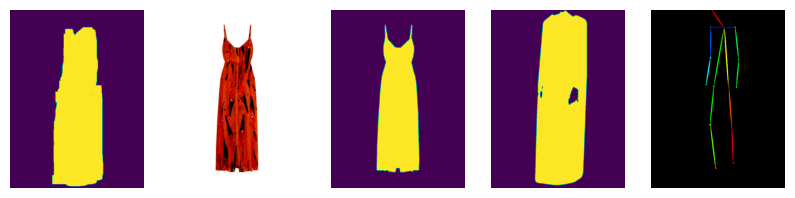

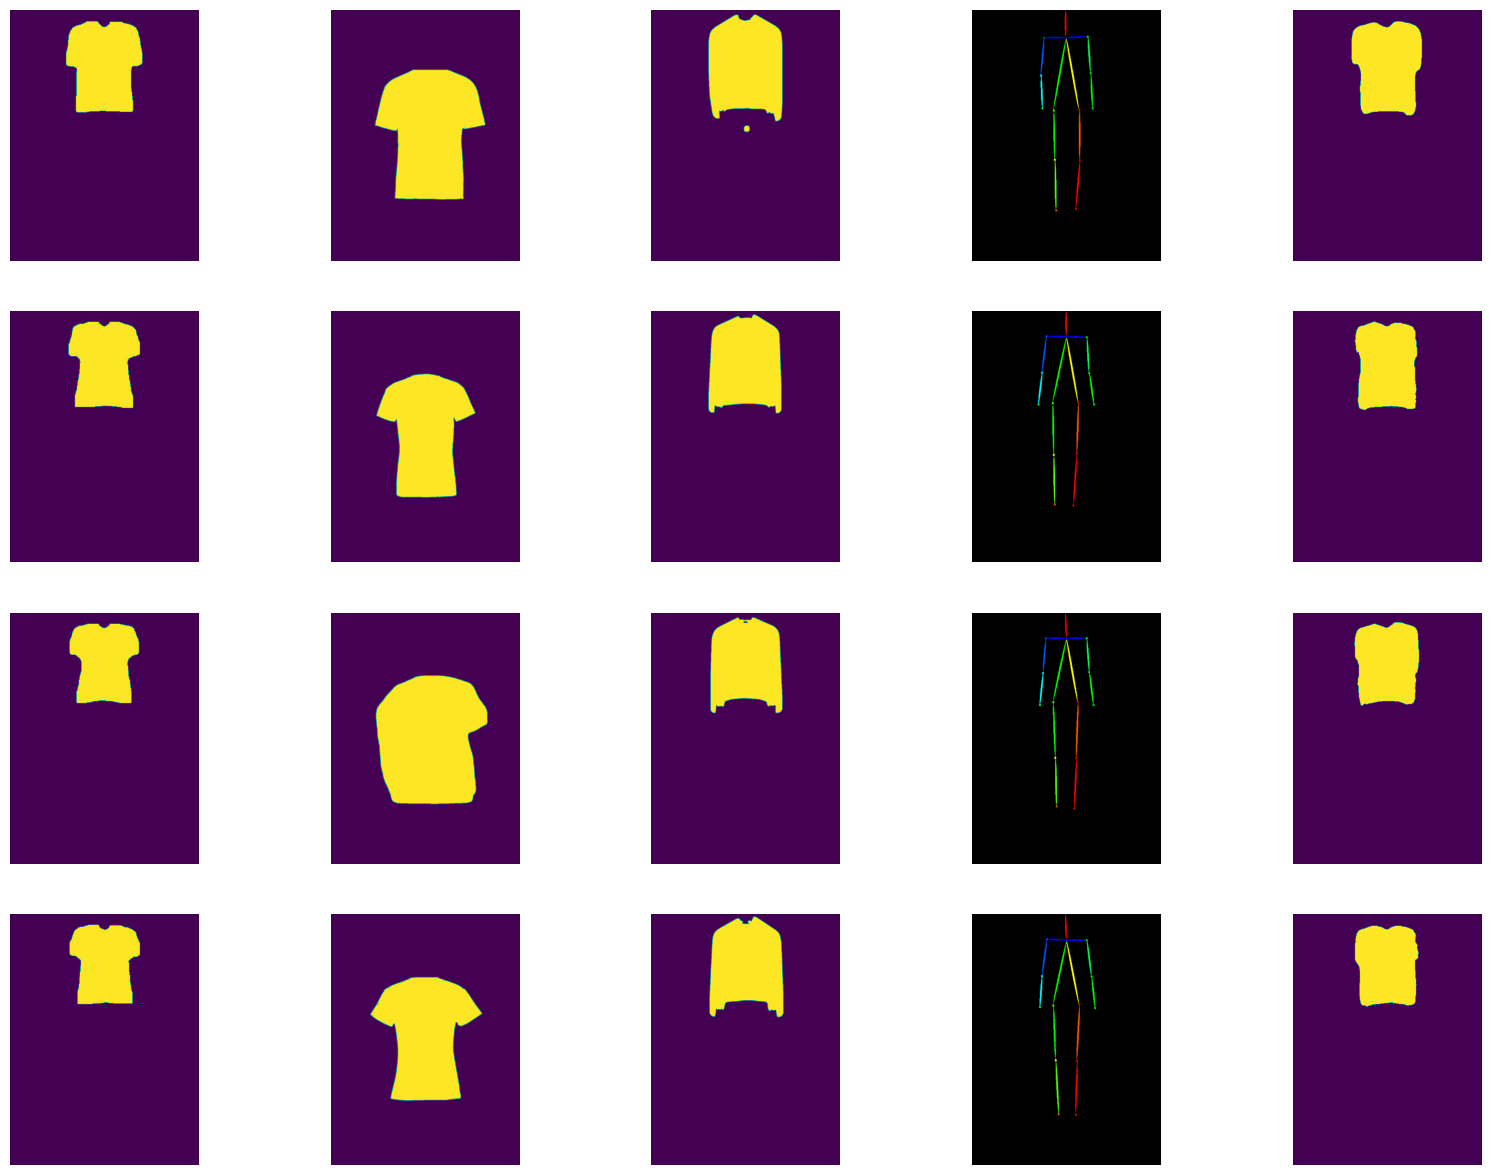

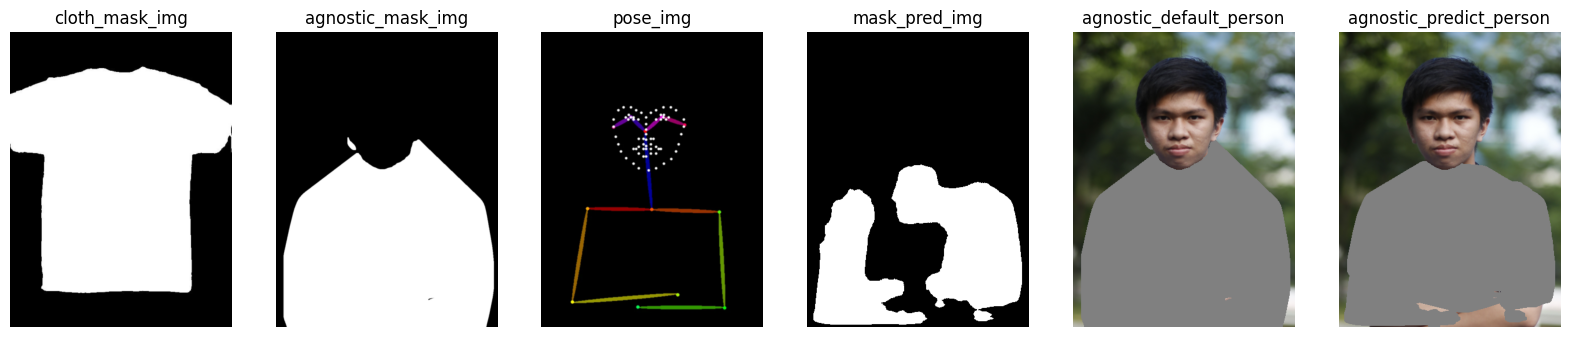

In [32]:
%matplotlib inline

plt.figure(figsize=(20,15))

plt.subplot(1, 6, 1)
plt.imshow(cloth_mask_img)
plt.title("cloth_mask_img")
plt.axis('off')

plt.subplot(1, 6, 2)
plt.imshow(agnostic_mask_img)
plt.title("agnostic_mask_img")
plt.axis('off')

plt.subplot(1, 6, 3)
plt.imshow(pose_img)
plt.title("pose_img")
plt.axis('off')

plt.subplot(1, 6, 4)
plt.imshow(mask_pred_img)
plt.title("mask_pred_img")
plt.axis('off')

plt.subplot(1, 6, 5)
plt.imshow(agnostic_default_person)
plt.title("agnostic_default_person")
plt.axis('off')

plt.subplot(1, 6, 6)
plt.imshow(agnostic_predict_person)
plt.title("agnostic_predict_person")
plt.axis('off')

plt.show()

In [33]:
category = "dresses"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_unpaired.txt")
# annotations_file = os.path.join(DATASET_DIR, category, "test_pairs.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]

for i in range(len(image_pairs))[40:44]:
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    result.append(r)

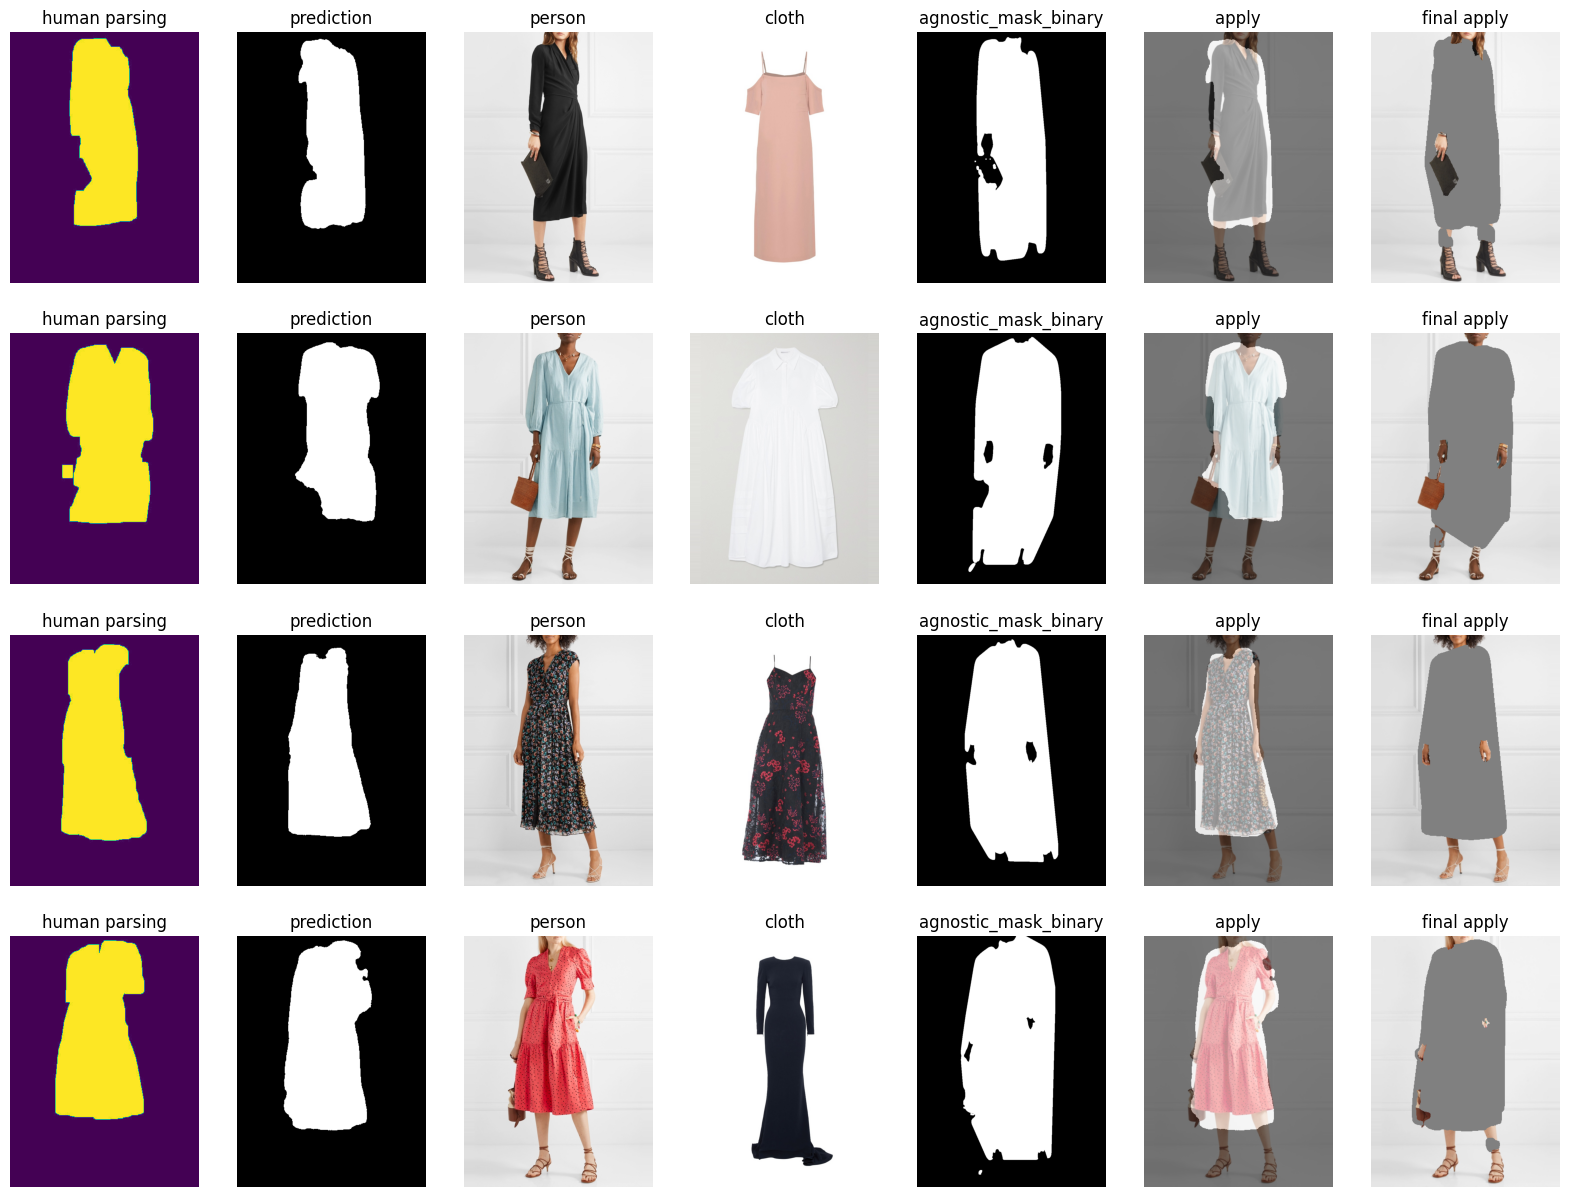

In [34]:
# Hiển thị một vài hình ảnh người
plt.figure(figsize=(20, 15))

p = 1

for i in range(4):

    plt.subplot(4, 7, p)
    plt.imshow(result[i]["grouth_truth"])
    plt.title("human parsing")
    plt.axis('off')

    plt.subplot(4, 7, p + 1)
    plt.imshow(result[i]["pred_mask"])
    plt.title("prediction")
    plt.axis('off')

    plt.subplot(4, 7, p + 2)
    plt.imshow(result[i]["person"])
    plt.title("person")
    plt.axis('off')

    plt.subplot(4, 7, p + 3)
    plt.imshow(result[i]["cloth_image"])
    plt.title("cloth")
    plt.axis('off')

    plt.subplot(4, 7, p + 4)
    plt.imshow(result[i]["agnostic_mask_binary"])
    plt.title("agnostic_mask_binary")
    plt.axis('off')
    
    pred_mask = np.array(result[i]["pred_mask"].convert("L"))
    final_mask = np.array(result[i]["final_mask_compose"]["result"].convert("L"))
    # final_mask = result[i]["final_mask_compose"]["strong_mask_area"]
    
    person = transforms.Resize(config.image_size)(result[i]["person"])
    
    plt.subplot(4, 7, p + 5)
    plt.imshow(person, alpha=0.9)
    plt.imshow(pred_mask, cmap='gray', alpha=0.5)
    plt.title("apply")
    plt.axis('off')
    
    ground_truth = transforms.Resize(config.image_size)(result[i]["grouth_truth"])
    
#     image_parse_v3_binary = np.array(ground_truth) == 255
        
#     pred_mask = np.squeeze(pred_mask, axis=-1)
    
#     print(pred_mask.shape)
    
#     print("parse shape", image_parse_v3_binary.shape)
    
#     final_mask = np.logical_or(pred_mask, image_parse_v3_binary)
        
    plt.subplot(4, 7, p + 6)
    person = np.array(person)
    person[final_mask == 1] = [128, 128, 128]
    # person[final_mask] = [128, 128, 128]
    person = Image.fromarray(person)
    plt.imshow(person)
    # plt.imshow(person, alpha=0.5)
    # plt.imshow(final_mask, cmap='gray', alpha=0.5)
    plt.title("final apply")
    plt.axis('off')
    
    p += 7

plt.show()

In [35]:
category = "upper_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_unpaired.txt")
# annotations_file = os.path.join(DATASET_DIR, category, "test_pairs.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]

for i in range(len(image_pairs))[56:60]:
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    result.append(r)

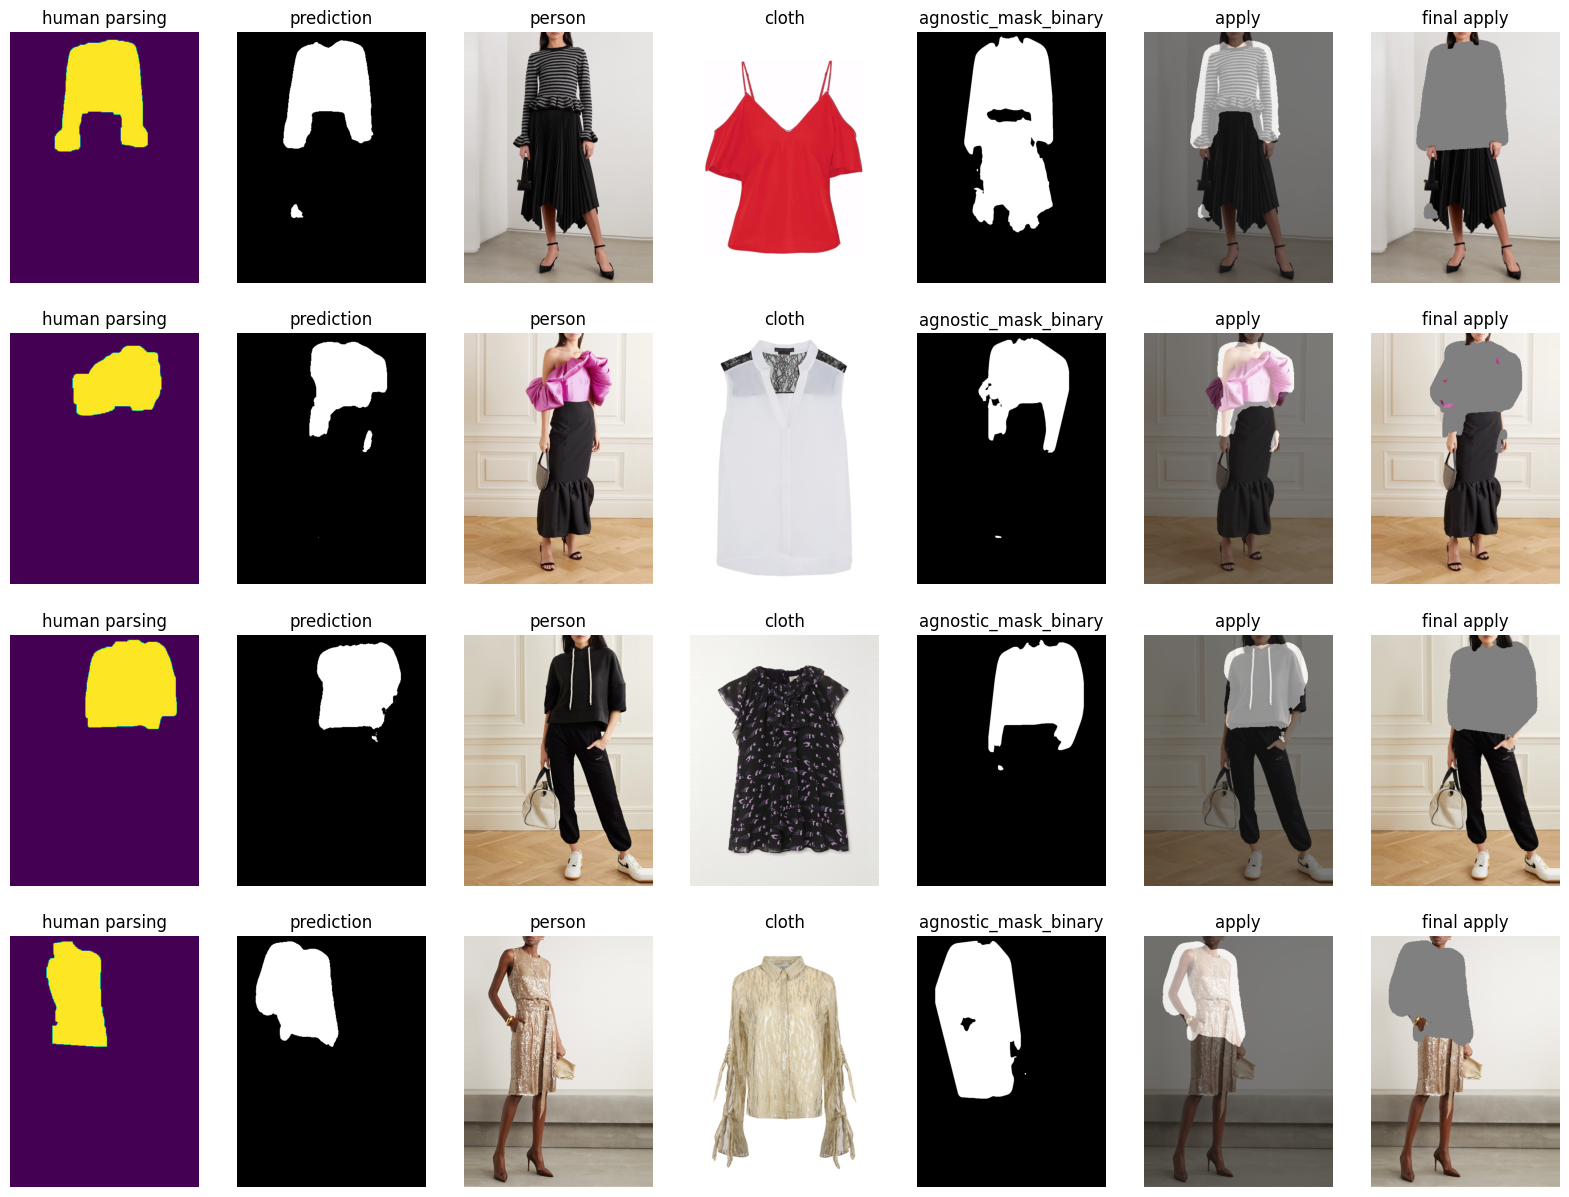

In [36]:
# Hiển thị một vài hình ảnh người
plt.figure(figsize=(20, 15))

p = 1

for i in range(4):

    plt.subplot(4, 7, p)
    plt.imshow(result[i]["grouth_truth"])
    plt.title("human parsing")
    plt.axis('off')

    plt.subplot(4, 7, p + 1)
    plt.imshow(result[i]["pred_mask"])
    plt.title("prediction")
    plt.axis('off')

    plt.subplot(4, 7, p + 2)
    plt.imshow(result[i]["person"])
    plt.title("person")
    plt.axis('off')

    plt.subplot(4, 7, p + 3)
    plt.imshow(result[i]["cloth_image"])
    plt.title("cloth")
    plt.axis('off')

    plt.subplot(4, 7, p + 4)
    plt.imshow(result[i]["agnostic_mask_binary"])
    plt.title("agnostic_mask_binary")
    plt.axis('off')
    
    pred_mask = np.array(result[i]["pred_mask"].convert("L"))
    final_mask = np.array(result[i]["final_mask_compose"]["result"].convert("L"))
    # final_mask = result[i]["final_mask_compose"]["strong_mask_area"]
    
    person = transforms.Resize(config.image_size)(result[i]["person"])
    
    plt.subplot(4, 7, p + 5)
    plt.imshow(person, alpha=0.9)
    plt.imshow(pred_mask, cmap='gray', alpha=0.5)
    plt.title("apply")
    plt.axis('off')
    
    ground_truth = transforms.Resize(config.image_size)(result[i]["grouth_truth"])
    
#     image_parse_v3_binary = np.array(ground_truth) == 255
        
#     pred_mask = np.squeeze(pred_mask, axis=-1)
    
#     print(pred_mask.shape)
    
#     print("parse shape", image_parse_v3_binary.shape)
    
#     final_mask = np.logical_or(pred_mask, image_parse_v3_binary)
        
    plt.subplot(4, 7, p + 6)
    person = np.array(person)
    person[final_mask == 1] = [128, 128, 128]
    # person[final_mask] = [128, 128, 128]
    person = Image.fromarray(person)
    plt.imshow(person)
    # plt.imshow(person, alpha=0.5)
    # plt.imshow(final_mask, cmap='gray', alpha=0.5)
    plt.title("final apply")
    plt.axis('off')
    
    p += 7

plt.show()

In [37]:
category = "lower_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_unpaired.txt")
# annotations_file = os.path.join(DATASET_DIR, category, "test_pairs.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]

for i in range(len(image_pairs))[52:56]:
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    result.append(r)

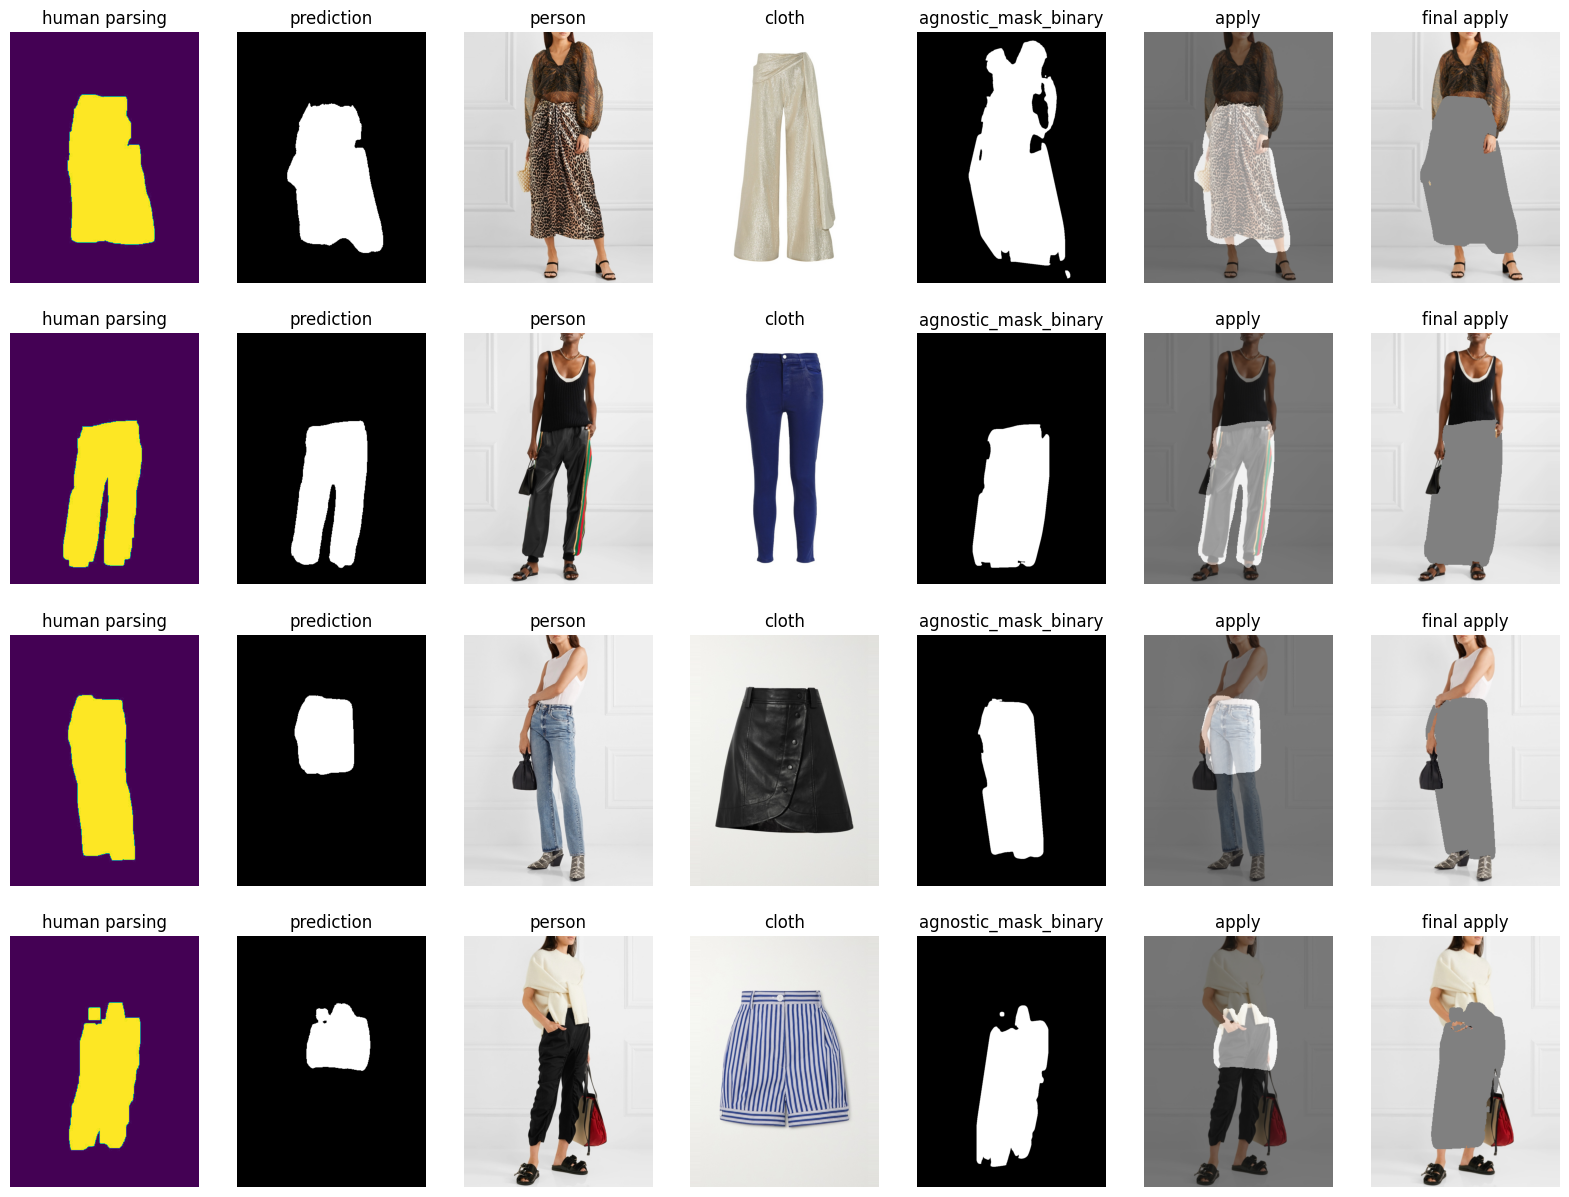

In [38]:
# Hiển thị một vài hình ảnh người
plt.figure(figsize=(20, 15))

p = 1

for i in range(4):

    plt.subplot(4, 7, p)
    plt.imshow(result[i]["grouth_truth"])
    plt.title("human parsing")
    plt.axis('off')

    plt.subplot(4, 7, p + 1)
    plt.imshow(result[i]["pred_mask"])
    plt.title("prediction")
    plt.axis('off')

    plt.subplot(4, 7, p + 2)
    plt.imshow(result[i]["person"])
    plt.title("person")
    plt.axis('off')

    plt.subplot(4, 7, p + 3)
    plt.imshow(result[i]["cloth_image"])
    plt.title("cloth")
    plt.axis('off')

    plt.subplot(4, 7, p + 4)
    plt.imshow(result[i]["agnostic_mask_binary"])
    plt.title("agnostic_mask_binary")
    plt.axis('off')
    
    pred_mask = np.array(result[i]["pred_mask"].convert("L"))
    final_mask = np.array(result[i]["final_mask_compose"]["result"].convert("L"))
    # final_mask = result[i]["final_mask_compose"]["accessory_protect_area"]
    
    person = transforms.Resize(config.image_size)(result[i]["person"])
    
    plt.subplot(4, 7, p + 5)
    plt.imshow(person, alpha=0.9)
    plt.imshow(pred_mask, cmap='gray', alpha=0.5)
    plt.title("apply")
    plt.axis('off')
    
    ground_truth = transforms.Resize(config.image_size)(result[i]["grouth_truth"])
        
    plt.subplot(4, 7, p + 6)
    person = np.array(person)
    person[final_mask == 1] = [128, 128, 128]
    # person[final_mask] = [128, 128, 128]
    person = Image.fromarray(person)
    plt.imshow(person)
    # plt.imshow(person, alpha=0.5)
    # plt.imshow(final_mask, cmap='gray', alpha=0.5)
    plt.title("final apply")
    plt.axis('off')
    
    p += 7

plt.show()

# Apply for test

In [53]:
dress_result = []
upper_result = []
lower_result = []

## Paired

In [ ]:
category = "dresses"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]


# j = 1
    
for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    result = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    final_mask_image = np.array(result["final_mask_compose"]["result"].convert("L"))*255
    
    final_mask_image = Image.fromarray(final_mask_image).convert("RGB")

    final_mask_image = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask_image)
    
    final_mask_image.save(os.path.join(DATASET_DIR, category, "mask-test-paired-v3", person_img_name))

In [62]:
category = "lower_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]
    
for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    result = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    final_mask_image = np.array(result["final_mask_compose"]["result"].convert("L"))*255
    
    final_mask_image = Image.fromarray(final_mask_image).convert("RGB")

    final_mask_image = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask_image)
    
    final_mask_image.save(os.path.join(DATASET_DIR, category, "mask-test-paired-v3", person_img_name))

100%|██████████| 1800/1800 [15:33<00:00,  1.93it/s]


In [63]:
category = "upper_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]
    
for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    result = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    final_mask_image = np.array(result["final_mask_compose"]["result"].convert("L"))*255
    
    final_mask_image = Image.fromarray(final_mask_image).convert("RGB")

    final_mask_image = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask_image)
    
    final_mask_image.save(os.path.join(DATASET_DIR, category, "mask-test-paired-v3", person_img_name))

100%|██████████| 1800/1800 [15:40<00:00,  1.91it/s]


## Unpaired

In [64]:
category = "dresses"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_unpaired.txt")
# annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]


for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    result = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    final_mask_image = np.array(result["final_mask_compose"]["result"].convert("L"))*255
    
    final_mask_image = Image.fromarray(final_mask_image).convert("RGB")

    final_mask_image = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask_image)
    
    final_mask_image.save(os.path.join(DATASET_DIR, category, "mask-test-unpaired-v3", person_img_name))

100%|██████████| 1800/1800 [16:20<00:00,  1.84it/s]


In [65]:
category = "lower_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_unpaired.txt")
# annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]


for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    result = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    final_mask_image = np.array(result["final_mask_compose"]["result"].convert("L"))*255
    
    final_mask_image = Image.fromarray(final_mask_image).convert("RGB")

    final_mask_image = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask_image)
    
    final_mask_image.save(os.path.join(DATASET_DIR, category, "mask-test-unpaired-v3", person_img_name))

100%|██████████| 1800/1800 [15:50<00:00,  1.89it/s]


In [66]:
category = "upper_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_unpaired.txt")
# annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]


for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    result = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    final_mask_image = np.array(result["final_mask_compose"]["result"].convert("L"))*255
    
    final_mask_image = Image.fromarray(final_mask_image).convert("RGB")

    final_mask_image = transforms.Resize((1024, 768), interpolation=transforms.InterpolationMode.NEAREST)(final_mask_image)
    
    final_mask_image.save(os.path.join(DATASET_DIR, category, "mask-test-unpaired-v3", person_img_name))

100%|██████████| 1800/1800 [15:09<00:00,  1.98it/s]


# Test evaluation

In [39]:
result = {}

In [40]:
category = "upper_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result[category] = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]
    
for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    
    ground_truth = np.array(transforms.Resize(config.image_size)(r["grouth_truth"]))
    
    ground_truth = (ground_truth == 255)
    
    # prediction = r["pred_mask"].cpu() > 0.5
    prediction = torch.from_numpy(np.array(r["pred_mask"].convert("L"))) > 0
    
    ground_truth = torch.from_numpy(ground_truth).unsqueeze(0).unsqueeze(0)
    
    prediction = prediction.unsqueeze(0).unsqueeze(0)
    
    # print(prediction.shape)
    # print(ground_truth.shape)
    
    iou = iou_score(prediction, ground_truth)
    
    result[category].append(iou[0])

100%|██████████| 1800/1800 [17:56<00:00,  1.67it/s]


In [41]:
category = "dresses"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result[category] = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]
    
for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    
    ground_truth = np.array(transforms.Resize(config.image_size)(r["grouth_truth"]))
    
    ground_truth = (ground_truth == 255)
    
    # prediction = r["pred_mask"].cpu() > 0.5
    prediction = torch.from_numpy(np.array(r["pred_mask"].convert("L"))) > 0
    
    ground_truth = torch.from_numpy(ground_truth).unsqueeze(0).unsqueeze(0)
    
    prediction = prediction.unsqueeze(0).unsqueeze(0)
    
    # print(prediction.shape)
    # print(ground_truth.shape)
    
    iou = iou_score(prediction, ground_truth)
    
    result[category].append(iou[0])

100%|██████████| 1800/1800 [17:41<00:00,  1.70it/s]


In [42]:
category = "lower_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result[category] = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]
    
for i in tqdm(range(len(image_pairs))):
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    
    ground_truth = np.array(transforms.Resize(config.image_size)(r["grouth_truth"]))
    
    ground_truth = (ground_truth == 255)
    
    # prediction = r["pred_mask"].cpu() > 0.5
    prediction = torch.from_numpy(np.array(r["pred_mask"].convert("L"))) > 0
    
    ground_truth = torch.from_numpy(ground_truth).unsqueeze(0).unsqueeze(0)
    
    prediction = prediction.unsqueeze(0).unsqueeze(0)
    
    # print(prediction.shape)
    # print(ground_truth.shape)
    
    iou = iou_score(prediction, ground_truth)
    
    result[category].append(iou[0])

100%|██████████| 1800/1800 [17:54<00:00,  1.68it/s]


In [43]:
a = result['upper_body'] + result['dresses'] + result['lower_body']
sum(a)/len(a)

0.849753206540589

VITON-HD Test Mask IOU: 0.8242

## Analyzing result

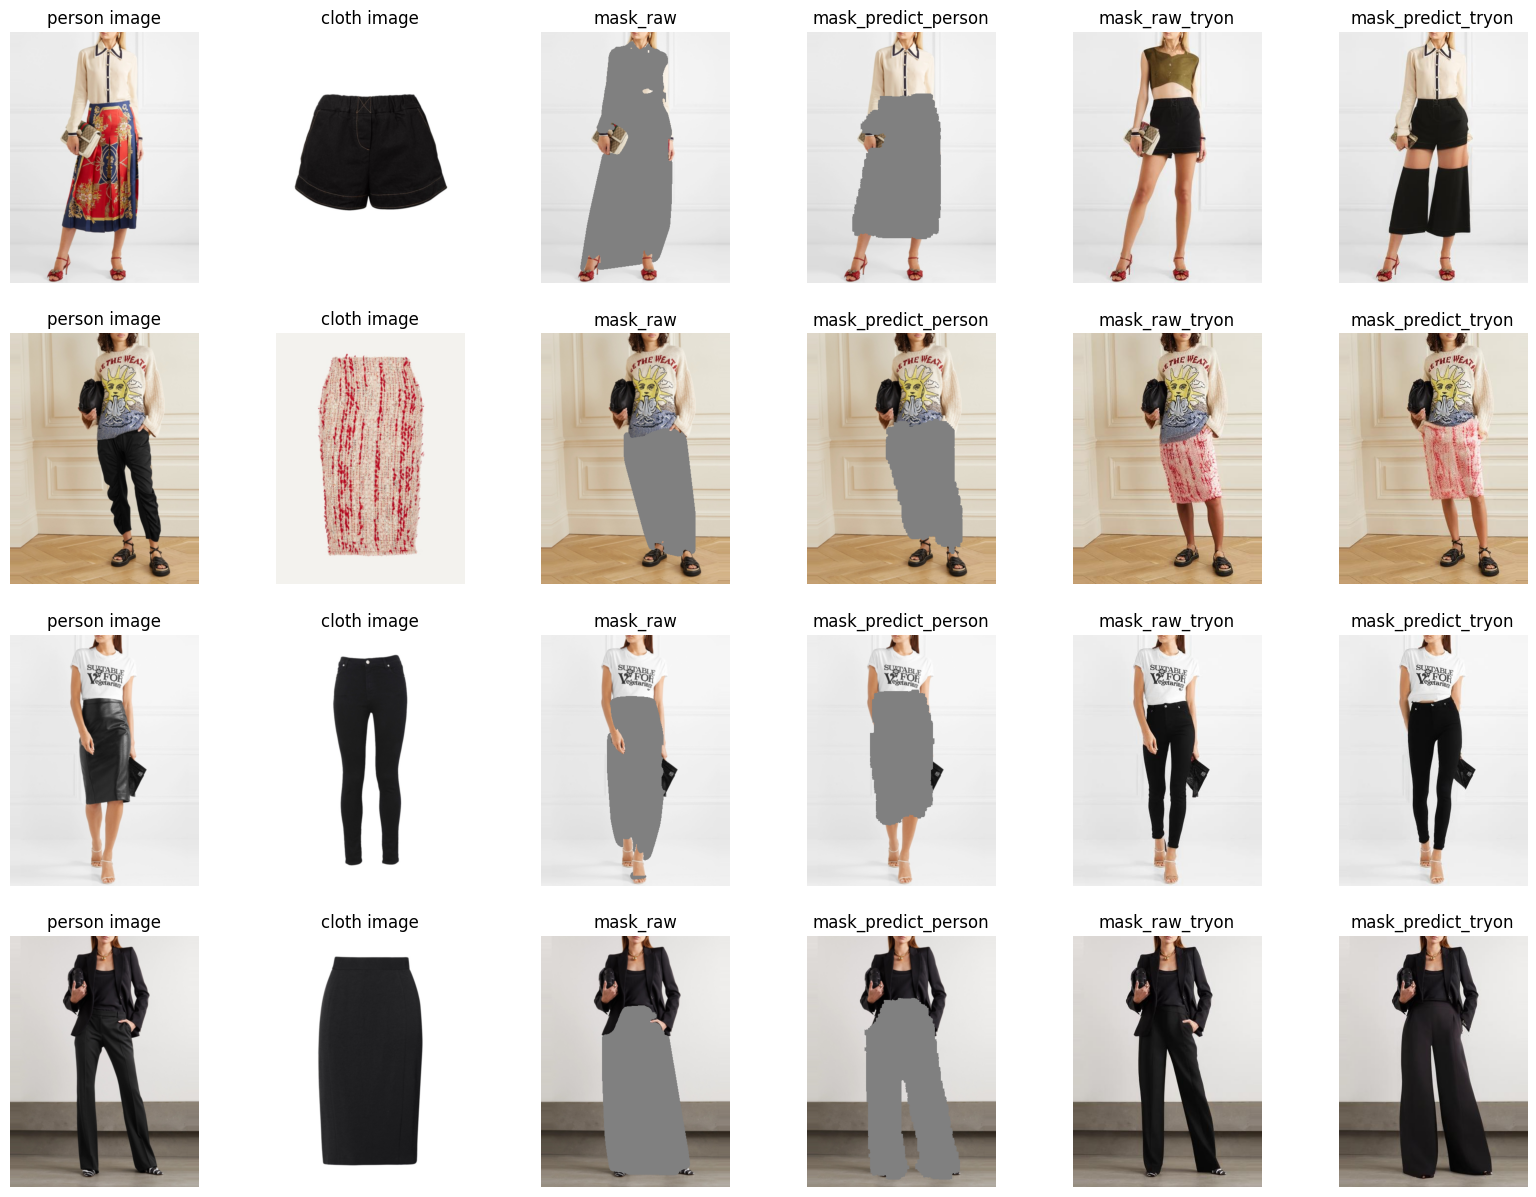

In [50]:
category = "lower_body"

dataset_folder_path = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_unpaired.txt")
# annotations_file = os.path.join(DATASET_DIR, category, "test_pairs.txt")

result = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]

p = 1

plt.figure(figsize=(20, 15))
    
for i in range(len(image_pairs))[20:24]:
    person_img_name, cloth_img_name = image_pairs[i]
    
    person_image = transforms.Resize(config.image_size)(Image.open(os.path.join(dataset_folder_path, category, "images", person_img_name)).convert("RGB"))
    
    cloth_image = transforms.Resize(config.image_size)(Image.open(os.path.join(dataset_folder_path, category, "images", cloth_img_name)).convert("RGB"))
    
    mask_raw = transforms.Resize(config.image_size)(Image.open(os.path.join(dataset_folder_path, category, "agnostic_masks", person_img_name.replace(".jpg", ".png"))).convert("L"))
    
    mask_predict = transforms.Resize(config.image_size)(Image.open(os.path.join(dataset_folder_path, category, "mask-test-paired-v2", person_img_name)).convert("L"))
    
    mask_raw_tryon = Image.open(os.path.join("../vinhdq_phucnph/output_CatVTON_DressCode/output_catVTON/dresscode-512/unpaired", category, person_img_name))
    
    mask_predict_tryon = Image.open(os.path.join("../vinhdq_phucnph/output_CatVTON_DressCode/output-v2/dresscode-512/unpaired", category, person_img_name))
    
    tmp1 = np.array(person_image)
    tmp2 = np.array(person_image)
    
    mask_raw = np.array(mask_raw)
    
    mask_predict = np.array(mask_predict)
    
    tmp1[mask_raw == 255] = [128, 128, 128]
    tmp2[mask_predict == 255] = [128, 128, 128]
    
    mask_raw_person = Image.fromarray(tmp1).convert("RGB")
    
    mask_predict_person = Image.fromarray(tmp2).convert("RGB")
    
    plt.subplot(4, 6, p)
    plt.imshow(person_image)
    plt.title("person image")
    plt.axis('off')

    plt.subplot(4, 6, p + 1)
    plt.imshow(cloth_image)
    plt.title("cloth image")
    plt.axis('off')
    
    plt.subplot(4, 6, p + 2)
    plt.imshow(mask_raw_person)
    plt.title("mask_raw")
    plt.axis('off')
    
    plt.subplot(4, 6, p + 3)
    plt.imshow(mask_predict_person)
    plt.title("mask_predict_person")
    plt.axis('off')
    
    plt.subplot(4, 6, p + 4)
    plt.imshow(mask_raw_tryon)
    plt.title("mask_raw_tryon")
    plt.axis('off')
    
    plt.subplot(4, 6, p + 5)
    plt.imshow(mask_predict_tryon)
    plt.title("mask_predict_tryon")
    plt.axis('off')
    
    p += 6

## evaluation

In [46]:
result_iou = {}
result = {}

In [51]:
category = "lower_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result_iou[category] = []
result[category] = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]
    
for i in tqdm(range(len(image_pairs))[:4]):
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    
    ground_truth = np.array(transforms.Resize(config.image_size)(r["grouth_truth"]))
    
    ground_truth = (ground_truth == 255)
    
    prediction = torch.from_numpy(np.array(r["pred_mask"].convert("L"))) > 0
    
    ground_truth = torch.from_numpy(ground_truth).unsqueeze(0).unsqueeze(0)
    
    prediction = prediction.unsqueeze(0).unsqueeze(0)
    
    # print(prediction.shape)
    # print(ground_truth.shape)
    
    iou = iou_score(prediction, ground_truth)
    
    result_iou[category].append(iou[0])
    result[category].append(r)

100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


In [56]:
category = "upper_body"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result_iou[category] = []
result[category] = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]
    
for i in tqdm(range(len(image_pairs))[:4]):
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    
    ground_truth = np.array(transforms.Resize(config.image_size)(r["grouth_truth"]))
    
    ground_truth = (ground_truth == 255)
    
    prediction = torch.from_numpy(np.array(r["pred_mask"].convert("L"))) > 0
    
    ground_truth = torch.from_numpy(ground_truth).unsqueeze(0).unsqueeze(0)
    
    prediction = prediction.unsqueeze(0).unsqueeze(0)
    
    # print(prediction.shape)
    # print(ground_truth.shape)
    
    iou = iou_score(prediction, ground_truth)
    
    result_iou[category].append(iou[0])
    result[category].append(r)

100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


In [57]:
category = "dresses"

DATASET_DIR = "../datasets/DressCode"

annotations_file = os.path.join(DATASET_DIR, category, "test_pairs_paired.txt")

result_iou[category] = []
result[category] = []

with open(annotations_file, 'r') as f:
    image_pairs = [line.strip().split() for line in f.readlines()]
    
for i in tqdm(range(len(image_pairs))[:4]):
    person_img_name, cloth_img_name = image_pairs[i]
    r = predict(unet, DATASET_DIR, category, person_img_name, cloth_img_name, device=config.device)
    
    ground_truth = np.array(transforms.Resize(config.image_size)(r["grouth_truth"]))
    
    ground_truth = (ground_truth == 255)
    
    prediction = torch.from_numpy(np.array(r["pred_mask"].convert("L"))) > 0
    
    ground_truth = torch.from_numpy(ground_truth).unsqueeze(0).unsqueeze(0)
    
    prediction = prediction.unsqueeze(0).unsqueeze(0)
    
    # print(prediction.shape)
    # print(ground_truth.shape)
    
    iou = iou_score(prediction, ground_truth)
    
    result_iou[category].append(iou[0])
    result[category].append(r)

100%|██████████| 4/4 [00:02<00:00,  1.60it/s]


In [59]:
result['dresses'][0].keys()

dict_keys(['agnostic_mask_binary', 'clothing_mask_binary', 'pose_image', 'pred_mask', 'final_mask_compose', 'cloth_image', 'grouth_truth', 'person', 'cloth'])

In [73]:
def func(category, p=1):

    person_image = result[category][0]['person'].resize((384, 512))
    cloth_image = result[category][0]['cloth']

    tmp1 = np.array(person_image)
    tmp2 = np.array(person_image)

    mask_predict = result[category][0]['pred_mask'].convert('L').resize((384, 512))

    mask_ground_truth = result[category][0]['grouth_truth'].convert('L').resize((384, 512))

    mask_predict = np.array(mask_predict)
    mask_ground_truth = np.array(mask_ground_truth)

    tmp1[mask_predict == mask_predict.max()] = [128, 128, 128]
    tmp2[mask_ground_truth == mask_ground_truth.max()] = [128, 128, 128]

    mask_predict_person = Image.fromarray(tmp1).convert("RGB")

    mask_ground_truth_person = Image.fromarray(tmp2).convert("RGB")

    plt.subplot(3, 4, p)
    plt.imshow(person_image)
    plt.title("person image")
    plt.axis('off')

    plt.subplot(3, 4, p + 1)
    plt.imshow(cloth_image)
    plt.title("cloth image")
    plt.axis('off')

    plt.subplot(3, 4, p + 2)
    plt.imshow(mask_ground_truth_person)
    plt.title("ground truth (mask)")
    plt.axis('off')

    plt.subplot(3, 4, p + 3)
    plt.imshow(mask_predict_person)
    plt.title(f"prediction (IOU={result_iou[category][0]:.2f})")
    plt.axis('off')
    p += 4

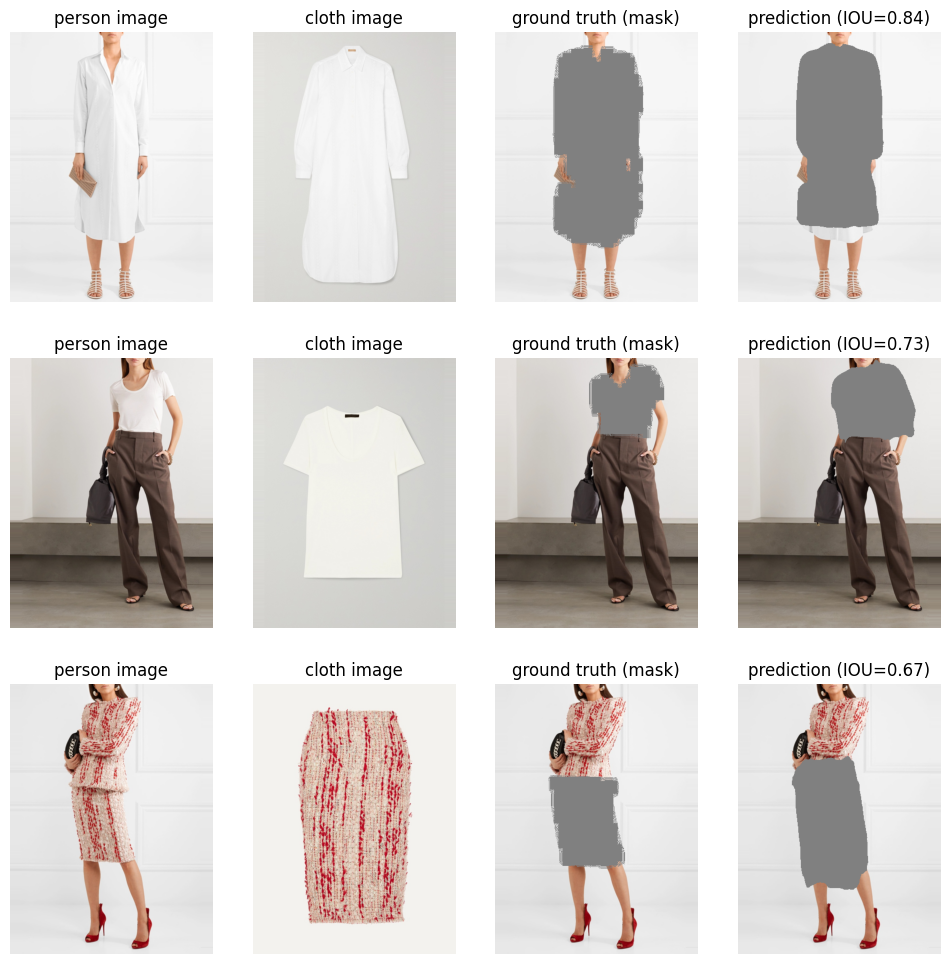

In [77]:
plt.figure(figsize=(12, 12))

func('dresses', 1)
func('upper_body', 5)
func('lower_body', 9)

plt.savefig("temp.png")